
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi




In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [ ]:
!pip install -q pybullet Box2D colorama
!nvidia-smi

Thu Sep  4 19:44:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.76.05              Driver Version: 580.76.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   67C    P0             13W /   35W |     160MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Import necessary packages.

In [ ]:
import os
import gym
import math
import time
import tqdm
import copy
import torch
import random
import argparse
import numpy as np
import pybullet_envs
import torch.nn as nn
from pathlib import Path
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import Video
from torch.distributions.normal import Normal

np.bool8 = np.bool_

import warnings
warnings.filterwarnings('ignore')

from colorama import Fore, Style, init as colorama_init
colorama_init(autoreset=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/home/amirmahdi/Codes/AI_Proj/.venv/lib/python3.11/site-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(


## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [ ]:
import shutil
if os.path.exists("videos"):
    shutil.rmtree("videos")


In [ ]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [ ]:
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

    def store_transition(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def load_batch(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(device),
            torch.FloatTensor(self.action[ind]).to(device),
            torch.FloatTensor(self.next_state[ind]).to(device),
            torch.FloatTensor(self.reward[ind]).to(device),
            torch.FloatTensor(self.not_done[ind]).to(device),
        )

## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [ ]:

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)

        return q1, q2



class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, log_std_min=-20, log_std_max=2):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)

        self.mean = nn.Linear(256, action_dim)
        self.log_std = nn.Linear(256, action_dim)

        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, state):
        x = self.l1(state)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)

        return mean, log_std

    def sample(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)

        dist = Normal(0, 1)
        e = dist.sample().to(device)
        action = torch.tanh(mean + e * std)
        log_prob = normal.log_prob(mean + e * std) - torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)

        return action, log_prob


class Value(nn.Module):
    def __init__(self, state_dim):
        super(Value, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        value = self.l3(x)
        return value


def make_env(name, seed: int):
    env = gym.make(name)
    env.seed(seed)
    env.action_space.seed(seed)
    return env

## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [ ]:
class Agent(object):
    def __init__(self, state_dim, action_dim, max_action, gamma=0.99, tau=0.005, alpha=0.2, lr=3e-4,
                 target_entropy=None, automatic_entropy_tuning=True):

        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha

        self.critic = Critic(state_dim, action_dim).to(device)
        self.target_critic = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr)

        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr)

        self.target_entropy = target_entropy if target_entropy else -action_dim
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optim = torch.optim.Adam([self.log_alpha], lr=lr)

        self.automatic_entropy_tuning = automatic_entropy_tuning

    def select_action(self, x, action=None):
        state = torch.FloatTensor(x).to(device).unsqueeze(0)
        action, _ = self.actor.sample(state)
        return action.detach().cpu().numpy()[0]

    def update_target(self):
        for param, target_param in zip(self.critic.parameters(), self.target_critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def update_critic(self, state, action, reward, next_state, not_done):
        with torch.no_grad():
            next_action, next_logprobs = self.actor.sample(next_state)
            current_Q1, current_Q2 = self.target_critic(next_state, next_action)
            min_Q = torch.min(current_Q1, current_Q2)
            Q_target = reward + not_done * self.gamma * (min_Q - self.alpha * next_logprobs)

        Q_1, Q_2 = self.critic(state, action)
        loss_1 = F.mse_loss(Q_1, Q_target)
        loss_2 = F.mse_loss(Q_2, Q_target)

        Q_loss = loss_1 + loss_2

        self.critic_optimizer.zero_grad()
        Q_loss.backward()
        self.critic_optimizer.step()

        return Q_loss

    def update_actor_and_alpha(self, state):
        action, logprobs = self.actor.sample(state)
        Q_1, Q_2 = self.critic(state, action)
        qval = torch.min(Q_1, Q_2)

        policy_loss = (self.alpha * logprobs - qval).mean()

        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (logprobs + self.target_entropy).detach()).mean()

            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()

            self.alpha = self.log_alpha.exp()
        else:
            alpha_loss = torch.tensor(0.).to(device)

        return policy_loss, alpha_loss

    def train(self, batch):
        state, action, next_state, reward, not_done = batch

        critic_loss = self.update_critic(state, action, reward, next_state, not_done)
        actor_loss, entropy_loss = self.update_actor_and_alpha(state)
        self.update_target()

        return {
            "critic_loss": critic_loss.item(),
            "actor_loss": actor_loss.item(),
            "alpha": self.alpha,
        }

    def save(self, filename):
        torch.save({
            'critic': self.critic.state_dict(),
            'actor': self.actor.state_dict()
        }, filename + "_sac.pth")


def eval_policy(agent, eval_env, eval_episodes=1, record_video=False, video_folder='videos', video_name='video'):
    rewards = np.zeros(eval_episodes)

    for i in range(eval_episodes):
        state, done = eval_env.reset(), False
        episode_reward = 0
        while not done:
            action = agent.select_action(np.array(state))
            state, reward, done, _ = eval_env.step(action)
            episode_reward += reward

        rewards[i] = episode_reward

    return {'returns': np.mean(rewards)}


def make_env(name, seed: int):
    env = gym.make(name)
    env.seed(seed)
    env.action_space.seed(seed)
    return env


## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [ ]:
SEED = 2025


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--env', default='HalfCheetahBulletEnv-v0')
    parser.add_argument('--max_timesteps', type=int, default=1_000_000,
                        help='total timesteps of the experiments')
    parser.add_argument("--save_model", action="store_true")
    parser.add_argument("--eval_freq", default=5_000, type=int)
    parser.add_argument("--batch_size", default=256, type=int)
    parser.add_argument('--alpha', type=float, default=0.2,
                        help='Determines the relative importance of the entropy term')
    parser.add_argument('--lr', type=float, default=3e-4,
                        help='the learning rate of the optimizer')
    parser.add_argument("--discount", default=0.99, type=float, help="Discount factor.")
    parser.add_argument('--tau', type=float, default=0.005, help='Target network update rate')
    parser.add_argument('--fixed_alpha', action="store_true")
    return parser.parse_args(args=[])


def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def build_agent_and_envs(args, seed: int):
    env = make_env(args.env, seed)
    eval_env = make_env(args.env, seed + 123)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent_kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "gamma": args.discount,
        "tau": args.tau,
        "alpha": args.alpha,
        "lr": args.lr,
        "automatic_entropy_tuning": not args.fixed_alpha,
    }

    agent = Agent(**agent_kwargs)
    return env, eval_env, agent, state_dim, action_dim


def make_experiment_name(env_name, fixed_alpha):
    algo_name = 'SAC_fixed_alpha' if fixed_alpha else 'SAC'
    return f"{env_name}"


def ensure_video_dir():
    Path("./videos").mkdir(parents=True, exist_ok=True)


## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

pybullet build time: Jan 29 2025 23:17:20


argv[0]=
argv[0]=
argv[0]=
argv[0]=
| Game:      1 | Score:    -842.98 | Best score:    -842.98 | Avg score:    -842.98 | Learning iter:          0 |
argv[0]=
argv[0]=
| Game:      2 | Score:    -914.93 | Best score:    -842.98 | Avg score:    -878.96 | Learning iter:       5000 |
| Game:      3 | Score:    -833.33 | Best score:    -833.33 | Avg score:    -863.75 | Learning iter:      10000 |
| Game:      4 | Score:    -167.29 | Best score:    -167.29 | Avg score:    -689.63 | Learning iter:      15000 |
| Game:      5 | Score:    -255.70 | Best score:    -167.29 | Avg score:    -602.85 | Learning iter:      20000 |
| Game:      6 | Score:      41.32 | Best score:      41.32 | Avg score:    -495.49 | Learning iter:      25000 |
| Game:      7 | Score:     498.00 | Best score:     498.00 | Avg score:    -353.56 | Learning iter:      30000 |
| Game:      8 | Score:     579.03 | Best score:     579.03 | Avg score:    -236.99 | Learning iter:      35000 |
| Game:      9 | Score:     566.87

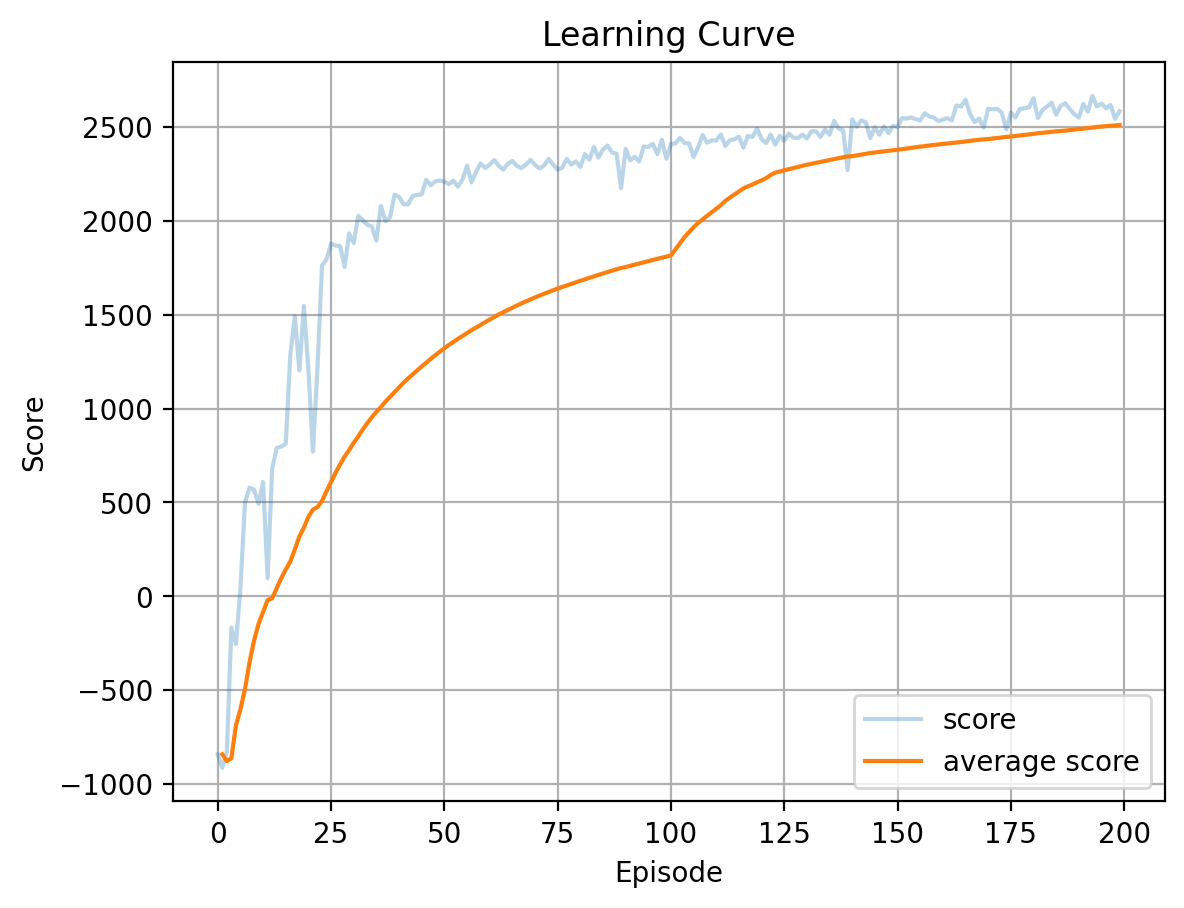

In [ ]:

def train_loop(args, env, eval_env, agent, replay_buffer, experiment_name, seed):
    state, done = env.reset(), False
    episode_timesteps = 0

    eval_runs = 0
    best_score = -math.inf
    eval_return_history = []

    for t in range(args.max_timesteps):
        episode_timesteps += 1
        action = agent.select_action(state)

        next_state, reward, done, _ = env.step(action)

        done_float = float(done) if episode_timesteps < env._max_episode_steps else 0.

        replay_buffer.store_transition(state, action, next_state, reward, done_float)

        state = next_state

        if done:
            state, done = env.reset(), False
            episode_timesteps = 0

        agent.train(replay_buffer.load_batch(args.batch_size))

        if t % args.eval_freq == 0:
            eval_info = eval_policy(agent, eval_env, eval_episodes=getattr(args, 'eval_episodes', 1))
            mean_return = float(eval_info.get('returns', 0.0))
            eval_runs += 1
            eval_return_history.append(mean_return)
            if mean_return > best_score:
                best_score = mean_return

            game = float(eval_runs)
            score = mean_return
            avg_score = float(np.mean(eval_return_history)) if eval_return_history else 0.0

            tqdm.tqdm.write(f'| Game: {game:6.0f} '
                f'| Score: {Fore.CYAN}{score:10.2f}{Style.RESET_ALL} '
                f'| Best score: {Fore.GREEN if best_score == score else Style.RESET_ALL}{best_score:10.2f}{Style.RESET_ALL} '
                f'| Avg score: {Fore.YELLOW}{avg_score:10.2f}{Style.RESET_ALL} '
                f'| Learning iter: {Fore.MAGENTA}{t:10.0f}{Style.RESET_ALL} |')

        if t % (args.max_timesteps // 20) == 0:
            video_env = gym.wrappers.RecordVideo(
                make_env(args.env, seed + 123),
                f"videos/{experiment_name}_{t}"
            )
            eval_policy(agent, video_env, eval_episodes=1)
            video_env.close()

    return eval_return_history


def main():
    args = parse_args()
    setup_seed(SEED)

    env, eval_env, agent, state_dim, action_dim = build_agent_and_envs(args, SEED)

    experiment_name = make_experiment_name(args.env, args.fixed_alpha)

    replay_buffer = ReplayBuffer(state_dim, action_dim)

    ensure_video_dir()

    eval_return_history = train_loop(args, env, eval_env, agent, replay_buffer, experiment_name, SEED)
    plot_learning_curve(np.array(eval_return_history), experiment_name)

    if args.save_model:
        agent.save(f"./{experiment_name}")

    env.close()

main()


## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [2]:
Video(f"./videos/HalfCheetahBulletEnv-v0_950000/rl-video-episode-0.mp4", embed=True, width=600)
